In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_ML_functions_and_feature_ranking as functions
import RF_target_predicting_and_learning_curves_functions as tp_lc_functions

from scipy.optimize import curve_fit

In [11]:
import os
# os.mkdir('TNG300-SAM_images/v9_TNG300-SAM_PhysEqn_SpinNormVdisk2')

In [2]:
df_1 = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/df_1_Normalized_as_defined_in_TNG300notebook_v6')
df_1_raw = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/df_1_Raw_as_defined_in_TNG300notebook_v6')

df_2 = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/df_2_Normalized_as_defined_in_TNG300notebook_v6')
df_2_raw = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/df_2_Raw_as_defined_in_TNG300notebook_v6')

df_3 = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/df_3_Normalized_as_defined_in_TNG300notebook_v6')
df_3_raw = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/df_3_Raw_as_defined_in_TNG300notebook_v6')

df_4 = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/df_4_Normalized_as_defined_in_TNG300notebook_v6')
df_4_raw = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/df_4_Raw_as_defined_in_TNG300notebook_v6')

print("df_1.shape", df_1.shape)
print("df_1_raw.shape", df_1_raw.shape)

print("df_2.shape", df_2.shape)
print("df_2_raw.shape", df_2_raw.shape)

print("df_3.shape", df_3.shape)
print("df_3_raw.shape", df_3_raw.shape)

print("df_4.shape", df_4.shape)
print("df_4_raw.shape", df_4_raw.shape)

df_1.shape (52053, 38)
df_1_raw.shape (52053, 59)
df_2.shape (64494, 38)
df_2_raw.shape (64494, 59)
df_3.shape (28372, 38)
df_3_raw.shape (28372, 59)
df_4.shape (13582, 38)
df_4_raw.shape (13582, 59)


### Curve_fit optimization for a*$\frac{M_{disk}}{M_{star}}^{b}$ * $\frac{Spin}{NormV_{disk}^{2}}$ for each Group 1-4 individually

In [5]:
def mdiskmstar_spin_vdisk2_func(spin_vdisk_diskmstar, a, b):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk_diskmstar[0]
    # NormVdisk is spin_vdisk_diskmstar[1]
    # Mdisk/Mstar is spin_vdisk_diskmstar[2]
    
    spin_use = np.copy(spin_vdisk_diskmstar[0])
    vdisk = np.copy(spin_vdisk_diskmstar[1])
    diskmstar = np.copy (spin_vdisk_diskmstar[2])
#     spin_use[spin_use < spin_min] = spin_min # no need for spin_use in TNG300 dataset since I introduced
# spin_effective in Notebook v6, where spin=0.02 for all spin<0.02.
    
    size = a*spin_use*(diskmstar)**b/vdisk**2 

    return size

In [3]:
def disks_physical_formula_func_v1 (df, group):
    
    """ This function takes a df as an input, then: a) extracts the size, spin and vdisk columns from the df, 
    b) forms a 2,M array with the spin & vdisk columns (called spin_vdisk)
    c) uses curve_fit to find the optimal parameters of spin_vdisk2_func (whose input is spin_vdisk and true size of the galaxies from the df)
    d) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on the complete dataset, df
    e) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on on the galaxies with low spin (spin<0.021)
    f) Plots the figure of the true size vs predicted size for each group of galaxy morphology (noted in the title)
    
    It returns: the spin_vdisk 2,M array, the optimal parameters and pcov from curve_fit, the size array obtained
    by applying spin_vdisk2_func on spin_vdisk with parameters obtained from curve_fit, and the
    figure comparing true size vs predicted size
    
    Note: the group input has to be in a string format"""
    
#   a)
    Size_true = np.array(df.loc[:, 'GalpropNormHalfRadius'])
    HalopropSpin = np.array(df.loc[:, 'HalopropSpin'])
    GalpropNormVdisk = np.array(df.loc[:, 'GalpropNormVdisk'])

    #   b) 
    spin_vdisk = [HalopropSpin, GalpropNormVdisk]
    spin_vdisk = np.array (spin_vdisk) # convert list into array
    
    BulgeMstar = np.array (df.loc[:, 'BulgeMstar_ratio'])
    
    Mdisk = np.array (df.loc[:, 'GalpropNormMdisk'])
    
    DiskMstar = np.array (df.loc[:, 'DiskMstar_ratio'])
    
    spin_vdisk_diskmstar = np. array([HalopropSpin, GalpropNormVdisk, DiskMstar])

#     spin_vdisk_bmstar = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar])

#   c)

    popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar, Size_true)
    
    size_func = mdiskmstar_spin_vdisk2_func(spin_vdisk_diskmstar, *popt)
#   d) R2 score of spin>0.02 galaxies
    r2_score_df = r2_score(Size_true, size_func)
    r2_score_df
#   e) R2 score of spin<0.02 galaxies
    df_spin_size = df.loc[:,['GalpropNormHalfRadius', 'HalopropSpin']]
    df_spin_size.loc[:, "Predicted"] = size_func
    zz = df_spin_size[df_spin_size.loc[:,'HalopropSpin']<=0.02]
    actual_size= zz['GalpropNormHalfRadius']
    predicted_size = zz['Predicted']
    r2_score_lowspin = r2_score(actual_size, predicted_size)

#   f) Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(7, 5))
    
    ax = plt.subplot()
    im = ax.scatter(Size_true, size_func, marker='.', s=10, alpha=0.7, 
                c  = df.loc[:,'BulgeMstar_ratio'],  
                cmap='Spectral_r', vmin=0.0, vmax=0.4,
#                 label=' colorbar: Mdisk/Mstar ratio \n fit: a=%5.3f \n c=%5.3f' % tuple(popt))
                label=r'colorbar:$\frac{M_{bulge}}{M_{star}}$' +  '\n fit: a=%5.3f \n b=%5.3f' % tuple(popt))
    ax.axis([0.0,0.2, 0.0,0.2])
    ax.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
    ax.text(0.02, 0.17, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_df), size=12)
    ax.text(0.02, 0.15, r'$R^{2}_{spin<0.02 gals}$=' + '{:.2f}'.format(r2_score(actual_size, predicted_size)), size=12)
    ax.set_title(r'Eqn= a*$(\frac{M_{disk}}{M_{star}})^{b}$*Spin/$NormVdisk^{2}$ ' + ' \n' + '{} '.format(group))
    ax.set_ylabel('Galaxy Size/Halo Size as predicted by size function')
    ax.set_xlabel('True Galaxy Size/Halo Size')
    ax.legend(loc = 'lower right', shadow=True)
    fig_prediction.colorbar(im, ax=ax)
    
    fig_prediction.tight_layout()
    # plt.savefig('BulgierDisks_TrueSize_vs_FunctionSize_15_wsmallgals.jpeg', dpi=500)
    plt.show()
    
    return spin_vdisk_diskmstar, popt, pcov, size_func, fig_prediction, r2_score_df, r2_score_lowspin

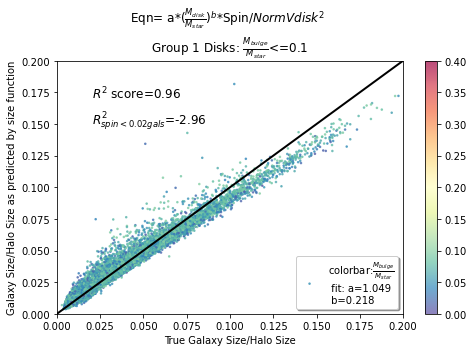

In [7]:
results_df_1 = disks_physical_formula_func_v1(df_1, group = r'Group 1 Disks: $\frac{M_{bulge}}{M_{star}}$<=0.1')
popt1 = results_df_1[1]

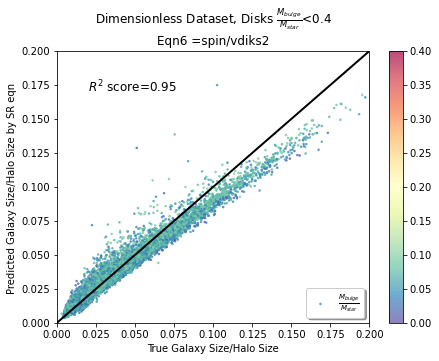

In [17]:
# 6th eqn by SR when using 3 features only:
#(((HalopropSpin - 0.0053429184) * pow(DiskMstar_ratio, 0.28800714)) / pow(GalpropNormVdisk, GalpropNormVdisk))

sr_disks_v1_3feateqn6 = df_1.loc[:, 'HalopropSpin']/df_1.loc[:, 'GalpropNormVdisk']**2

r2_score_disks_3feat_6=r2_score(df_1.loc[:, 'GalpropNormHalfRadius'], sr_disks_v1_3feateqn6)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_1.loc[:, 'GalpropNormHalfRadius'], sr_disks_v1_3feateqn6,
            c = df_1.loc[:, 'GalpropNormMbulge']/df_1.loc[:,'GalpropNormMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=0.4)
ax.text(0.02, 0.17, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_3feat_6), size=12)
ax.axis([0.0,0.2, 0.0,0.2])
ax.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
ax.set_title(r'Dimensionless Dataset, Disks $\frac{M_{bulge}}{M_{star}}$<0.4' + '\n'+ r'Eqn6 =spin/vdiks2')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG300-SAM_images/v7_TNG300-SAM_df_14/v7_Group14_SR_5theqn_3feat_disks_dimensionless.jpeg', dpi=500)
plt.show()

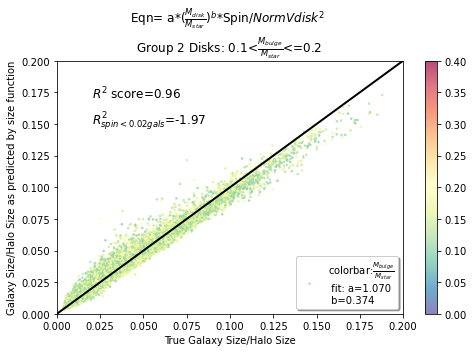

In [8]:
results_df_2 = disks_physical_formula_func_v1(df_2, group = r'Group 2 Disks: 0.1<$\frac{M_{bulge}}{M_{star}}$<=0.2')
popt2 = results_df_2[1]

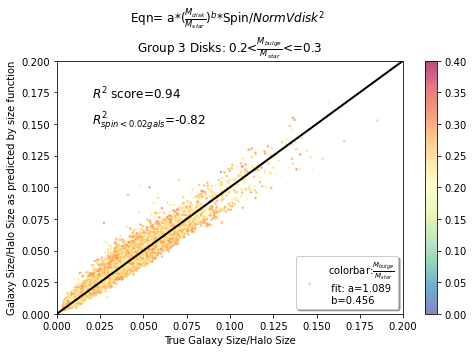

In [9]:
results_df_3 = disks_physical_formula_func_v1(df_3, group = r'Group 3 Disks: 0.2<$\frac{M_{bulge}}{M_{star}}$<=0.3')
popt3 = results_df_3[1]

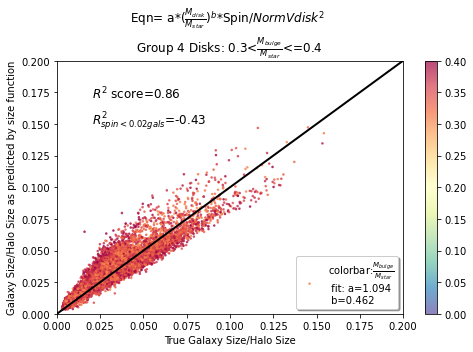

In [10]:
results_df_4 = disks_physical_formula_func_v1(df_4, group = r'Group 4 Disks: 0.3<$\frac{M_{bulge}}{M_{star}}$<=0.4')
popt4 = results_df_4[1]

In [15]:
# results_df_1[4].savefig('TNG300-SAM_images/v9_TNG300-SAM_PhysEqn_SpinNormVdisk2/v9_Group1_DiskMstarSpinVdisk2eqn_optimized.jpeg', dpi=500)
# results_df_2[4].savefig('TNG300-SAM_images/v9_TNG300-SAM_PhysEqn_SpinNormVdisk2/v9_Group2_DiskMstarSpinVdisk2eqn_optimized.jpeg', dpi=500)
# results_df_3[4].savefig('TNG300-SAM_images/v9_TNG300-SAM_PhysEqn_SpinNormVdisk2/v9_Group3_DiskMstarSpinVdisk2eqn_optimized.jpeg', dpi=500)
# results_df_4[4].savefig('TNG300-SAM_images/v9_TNG300-SAM_PhysEqn_SpinNormVdisk2/v9_Group4_DiskMstarSpinVdisk2eqn_optimized.jpeg', dpi=500)